## Library

In [ ]:
# !pip install numpy scikit-learn pandas yfinance tensorflow matplotlib
# !pip install tensorflow==2.12.0

In [2]:
# Data Preprocessing and Preparation
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


# Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

## Data preparation

In [3]:
df = yf.download('PTT.BK', start="2019-07-01", end="2024-06-30")
df.index = pd.to_datetime(df.index)
df.columns = df.columns.droplevel(1)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2019-07-01 00:00:00+00:00,38.007931,49.50,49.50,49.0,49.50,52067800
2019-07-02 00:00:00+00:00,37.240093,48.50,49.50,48.5,49.25,51490800
2019-07-03 00:00:00+00:00,37.048138,48.25,48.50,48.0,48.50,44524800
2019-07-04 00:00:00+00:00,37.048138,48.25,48.75,48.0,48.50,49509400
2019-07-05 00:00:00+00:00,37.048138,48.25,48.50,48.0,48.25,20907100


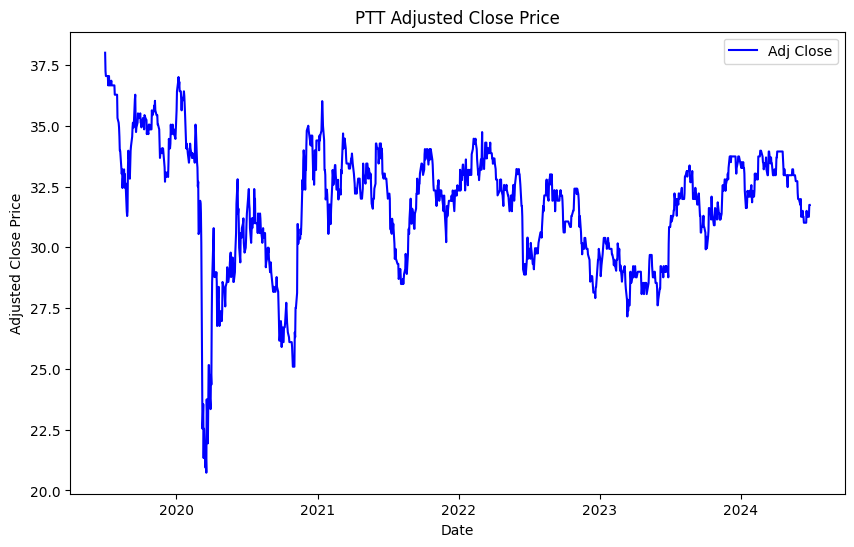

In [4]:
import matplotlib.pyplot as plt

# สมมติว่าคุณมี DataFrame ที่ชื่อว่า dataset ที่มีคอลัมน์ 'Adj Close' และ index เป็น datetime
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Adj Close'], label='Adj Close', color='blue')

# ตั้งชื่อกราฟ
plt.title('PTT Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')

# แสดง legend และ plot
plt.legend()
plt.show()


In [5]:
# function สำหรับ preprocess ข้อมูล time series หลายตัวแปร
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# เลือกข้อมูลหุ้นจาก list ของ DataFrame และ drop column 'Close' เนื่องจากเราจะใช้ column 'Adj. Close' เท่านั้น
df = df.drop('Close',axis=1)
dataset = df
values = dataset.values
values = values.astype('float32')


# ทำ scaling ข้อมูลด้วยวิธี min-max normalized scaling เปลี่ยน scale ข้อมูลแต่ละ column และเก็บค่า mean และ sd แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())


# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้
reframed = series_to_supervised(dataset.values, 15, 8,feat_name=df.columns)
reframed.drop(['High(t+1)','High(t+2)','High(t+3)','High(t+4)','High(t+5)','High(t+6)','High(t+7)','Low(t+1)','Low(t+2)','Low(t+3)','Low(t+4)','Low(t+5)','Low(t+6)','Low(t+7)',\
               'Open(t+1)','Open(t+2)','Open(t+3)','Open(t+4)','Open(t+5)','Open(t+6)','Open(t+7)','Volume(t+1)','Volume(t+2)','Volume(t+3)','Volume(t+4)','Volume(t+5)',\
               'Volume(t+6)','Volume(t+7)'],axis=1,inplace=True)

In [6]:
reframed.head()

,Adj Close(t-15),High(t-15),Low(t-15),Open(t-15),Volume(t-15),Adj Close(t-14),High(t-14),Low(t-14),Open(t-14),Volume(t-14),...,Low(t),Open(t),Volume(t),Adj Close(t+1),Adj Close(t+2),Adj Close(t+3),Adj Close(t+4),Adj Close(t+5),Adj Close(t+6),Adj Close(t+7)
15,1.000000,1.000000,1.000000,1.000000,0.080878,0.955565,1.000000,0.980315,0.990119,0.079982,...,0.940945,0.940711,0.032713,0.922238,0.922238,0.900021,0.900021,0.900021,0.900021,0.844476
16,0.955565,1.000000,0.980315,0.990119,0.079982,0.944456,0.957447,0.960630,0.960474,0.069161,...,0.931102,0.930830,0.053481,0.922238,0.900021,0.900021,0.900021,0.900021,0.844476,0.833368
17,0.944456,0.957447,0.960630,0.960474,0.069161,0.944456,0.968085,0.960630,0.960474,0.076904,...,0.940945,0.930830,0.031202,0.900021,0.900021,0.900021,0.900021,0.844476,0.833368,0.822259
18,0.944456,0.968085,0.960630,0.960474,0.076904,0.944456,0.957447,0.960630,0.950593,0.032475,...,0.921260,0.920949,0.064817,0.900021,0.900021,0.900021,0.844476,0.833368,0.822259,0.800041
19,0.944456,0.957447,0.960630,0.950593,0.032475,0.944456,0.946809,0.960630,0.940711,0.019224,...,0.921260,0.911067,0.036953,0.900021,0.900021,0.844476,0.833368,0.822259,0.800041,0.766714


In [7]:
values = reframed.values

# Define the number of days for each set
# ทำ train, val, test split
values = reframed.values
n_train_percent = 0.7
n_val_percent = 0.15
train_split = int(values.shape[0] * n_train_percent)
val_split = int(values.shape[0] * (n_train_percent + n_val_percent))

train = values[:train_split, :]
val = values[train_split:val_split, :]
test = values[val_split:, :]

# เก็บค่า datetime ของ train, val, test
date_reframed = dataset.index[reframed.index]
date_train = date_reframed[:train_split]
date_val = date_reframed[train_split:val_split]
date_test = date_reframed[val_split:]

# split feature และ target
train_X, train_y = train[:, :-7], train[:, -7:]
val_X, val_y = val[:, :-7], val[:, -7:]
test_X, test_y = test[:, :-7], test[:, -7:]

# reshape input ให้เป็น 3D (samples, timesteps, features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [8]:
# X (samples, timesteps, features)
# Y (samples , target)
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)
print(test_X.shape)
print(test_y.shape)

(832, 1, 80)
(832, 7)
(178, 1, 80)
(178, 7)
(179, 1, 80)
(179, 7)


## Create Model & Evaluate (ยังไม่ Hyperparameter tuning)


In [ ]:
model = Sequential()

# SimpleRNN layer with ReLU activation
# model.add(LSTM(units=70,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(units=70,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
# GRU layer with ReLU activation
model.add(GRU(units=70,activation='relu'))
model.add(Dropout(0.1))
# Output layer for 1 targets
# model.add(Dense(1,activation='sigmoid'))
model.add(Dense(1))
# Compile the model with  learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Compile the model
# model.compile(optimizer='adam', loss='mse',metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

In [ ]:
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(val_X, val_y),callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])



In [ ]:
# พล็อตค่า train&test loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc=1)
plt.xlabel('num_epoch')  # ตั้งชื่อแกน X เป็น num_epoch
plt.ylabel('MSE')        # ตั้งชื่อแกน Y เป็น MSE
plt.title('GRU-RNN Training process')
plt.show()

In [ ]:
results = model.evaluate(test_X, test_y)
print("Test Loss:", results[0])
print("Test RMSE:", results[1])

In [ ]:
# # ทำ prediction
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# # rescale ข้อมูลกลับ

# # Standardized -> actual
# # inv_yhat = (yhat * std_dict['Adj Close']) + mean_dict['Adj Close']
# # inv_y = (test_y * std_dict['Adj Close']) + mean_dict['Adj Close']
# # # Min-Max Normalized -> actual
# inv_yhat = yhat*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']
# inv_y = test_y*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']

In [ ]:
# ทำ prediction
yhat_train = model.predict(train_X)
yhat_val = model.predict(val_X)
yhat_test = model.predict(test_X)

# Reshape ข้อมูล (ถ้าจำเป็น)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Rescale ข้อมูลกลับ (ในกรณีใช้ Min-Max Normalization)
inv_yhat_train = yhat_train * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_val = yhat_val * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_test = yhat_test * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']

inv_y_train = train_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_val = val_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_test = test_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']


In [ ]:
# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(16, 5))
plt.plot(date_test, inv_y_test[:, 0], color='black', label='Actual Stock Price')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='Predicted Stock Price')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 3 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# ตั้งชื่อกราฟ
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# Visualizing Results
plt.figure(figsize=(16, 5))

# Actual prices
plt.plot(date_train, inv_y_train[:, 0], color='black', label='Actual_Adj_Close')
plt.plot(date_val, inv_y_val[:, 0], color='black')
plt.plot(date_test, inv_y_test[:, 0], color='black')

# Predicted prices
plt.plot(date_train, inv_yhat_train[:, 0], color='green', label='KBANK_predicted_train_set')
plt.plot(date_val, inv_yhat_val[:, 0], color='orange', label='KBANK_predicted_val_set')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='KBANK_predicted_test_set')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 6 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# ตั้งชื่อกราฟ
plt.title('KBANK_Adj_close_prediction')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Adj Close (THB)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# คำนวณ MAPE และ RMSE
mape = mean_absolute_percentage_error(inv_y_test, inv_yhat_test)*100
rmse = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))

# แสดงผลลัพธ์
print(f'MAPE: {mape:.4f}%')
print(f'RMSE: {rmse:.4f}')


## Hyperparameter Tuning

In [9]:
# Create the model
def create_model(lstm_units, gru_units, LR, L2,beta_1):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True, kernel_regularizer=l2(L2)))
    model.add(Dropout(0.1))
    model.add(GRU(gru_units, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(7))
    
    optimizer = Adam(learning_rate=LR, beta_1=beta_1, beta_2=0.999)
    model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# Define the hyperparameters to tune
param_dist = {
    'lstm_units': list(range(1, 101)),  # Correct parameter name
    'gru_units': list(range(1, 101)),
    'LR': np.linspace(0.001, 0.1, 100).tolist(),
    'L2': [0.001, 0.005, 0.01, 0.05, 0.1],
    'beta_1':[0.7,0.8,0.9]
}

# Wrap the model into a KerasRegressor
model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=64, verbose=0)

import time

start_time = time.time()


# Define the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                    n_iter=100, scoring='neg_root_mean_squared_error',
                                    cv=3, verbose=1, random_state=42, n_jobs=-1)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model using RandomizedSearchCV
random_search_result = random_search.fit(train_X, train_y, validation_data=(val_X, val_y), callbacks=[early_stopping])

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

/tmp/ipykernel_238861/1603465509.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=100, batch_size=64, verbose=0)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


2024-12-14 21:35:43.480425: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-14 21:35:43.490615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-14 21:35:43.493769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-14 21:35:43.502444: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-14 21:35:43.502807: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-14 21:35:43.502847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-14 21:35:43.502987: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-14 21:35:43.505101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-

Execution time: 1256.3745753765106 seconds


In [10]:
# Get the best parameters and the best score
best_params = random_search_result.best_params_
best_score = -random_search_result.best_score_


In [11]:
print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)

Best Parameters: {'lstm_units': 55, 'gru_units': 47, 'beta_1': 0.9, 'LR': 0.003, 'L2': 0.001}
Best RMSE Score: 0.07236677211489338


## After Hyperparameter Tuning

In [12]:
lstm_gru_model = create_model(lstm_units=55, gru_units=47,beta_1=0.9,LR=0.003,L2=0.001)
lstm_gru_model.summary()

2024-12-14 21:51:46.424746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-14 21:51:46.426851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-14 21:51:46.428004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 55)             29920     
                                                                 
 dropout_2 (Dropout)         (None, 1, 55)             0         
                                                                 
 gru_1 (GRU)                 (None, 47)                14664     
                                                                 
 dropout_3 (Dropout)         (None, 47)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 336       
                                                                 
Total params: 44,920
Trainable params: 44,920
Non-trainable params: 0
_________________________________________________________________


In [13]:
lstm_gru_history = lstm_gru_model.fit(train_X, train_y, epochs=150, batch_size=64, validation_data=(val_X, val_y),callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/150


2024-12-14 21:51:53.068219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-14 21:51:53.070384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-14 21:51:53.072154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 1/13 [=>............................] - ETA: 35s - loss: 0.5399 - root_mean_squared_error: 0.6484

2024-12-14 21:51:56.103010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-14 21:51:56.104963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-14 21:51:56.106378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 4s 75ms/step - loss: 0.2379 - root_mean_squared_error: 0.3672 - val_loss: 0.0953 - val_root_mean_squared_error: 0.1019
Epoch 2/150
13/13 [==============================] - 0s 6ms/step - loss: 0.1015 - root_mean_squared_error: 0.1735 - val_loss: 0.0645 - val_root_mean_squared_error: 0.0787
Epoch 3/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0708 - root_mean_squared_error: 0.1453 - val_loss: 0.0468 - val_root_mean_squared_error: 0.0774
Epoch 4/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0537 - root_mean_squared_error: 0.1366 - val_loss: 0.0348 - val_root_mean_squared_error: 0.0738
Epoch 5/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0428 - root_mean_squared_error: 0.1313 - val_loss: 0.0273 - val_root_mean_squared_error: 0.0745
Epoch 6/150
13/13 [==============================] - 0s 6ms/step - loss: 0.0352 - root_mean_squared_error: 0.1267 - val_loss: 0.0239 - val_root_mean_squared

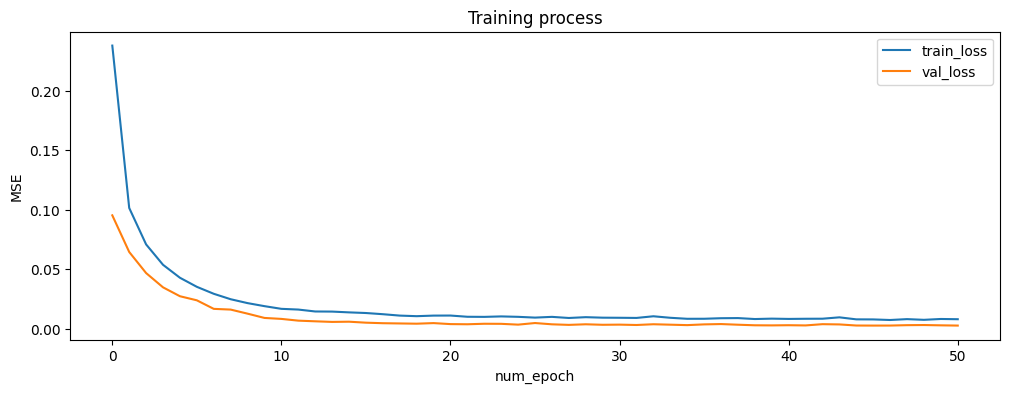

In [14]:
# พล็อตค่า train&test loss
plt.figure(figsize=(12, 4))
plt.plot(lstm_gru_history.history['loss'], label='train_loss')
plt.plot(lstm_gru_history.history['val_loss'], label='val_loss')
plt.legend(loc=1)
plt.xlabel('num_epoch')  # ตั้งชื่อแกน X เป็น num_epoch
plt.ylabel('MSE')        # ตั้งชื่อแกน Y เป็น MSE
plt.title('Training process')
plt.show()

In [15]:
results = lstm_gru_model.evaluate(test_X, test_y)
print("Test Loss:", results[0])
print("Test RMSE:", results[1])

6/6 [==============================] - 0s 2ms/step - loss: 0.0034 - root_mean_squared_error: 0.0496
Test Loss: 0.0034267501905560493
Test RMSE: 0.0496351420879364


In [16]:
# ทำ prediction
yhat_train = lstm_gru_model.predict(train_X)
yhat_val = lstm_gru_model.predict(val_X)
yhat_test = lstm_gru_model.predict(test_X)

# Reshape ข้อมูล (ถ้าจำเป็น)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Rescale ข้อมูลกลับ (ในกรณีใช้ Min-Max Normalization)
inv_yhat_train = yhat_train * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_val = yhat_val * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_yhat_test = yhat_test * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']

inv_y_train = train_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_val = val_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']
inv_y_test = test_y * (max_dict['Adj Close'] - min_dict['Adj Close']) + min_dict['Adj Close']


2024-12-14 21:52:07.671842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-14 21:52:07.673934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-14 21:52:07.675457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 1ms/step


2024-12-14 21:52:08.459621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-14 21:52:08.461539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-14 21:52:08.462818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 2ms/step


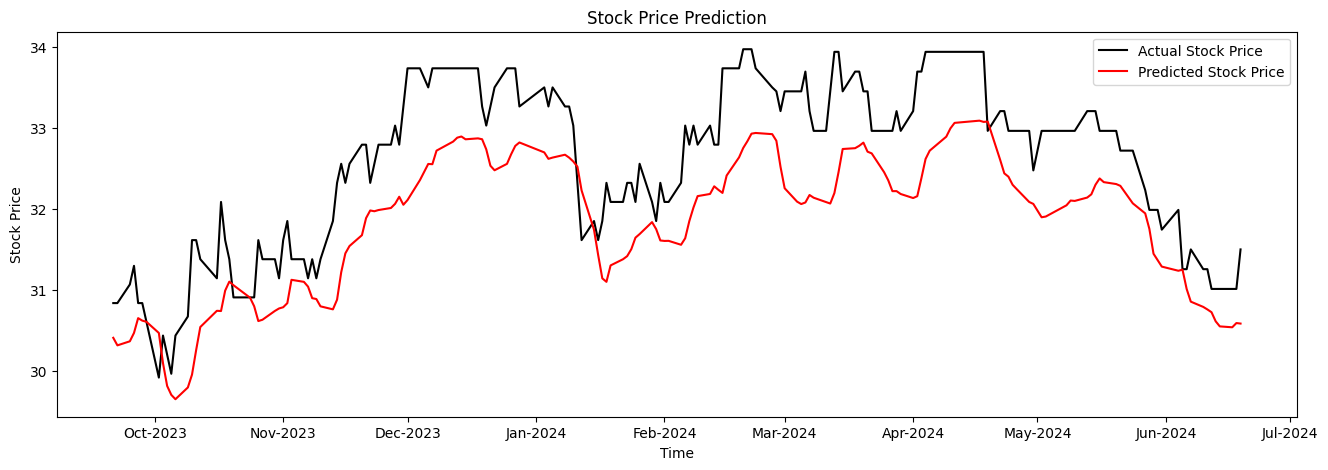

In [17]:
# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(16, 5))
plt.plot(date_test, inv_y_test[:, 0], color='black', label='Actual Stock Price')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='Predicted Stock Price')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 3 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# ตั้งชื่อกราฟ
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

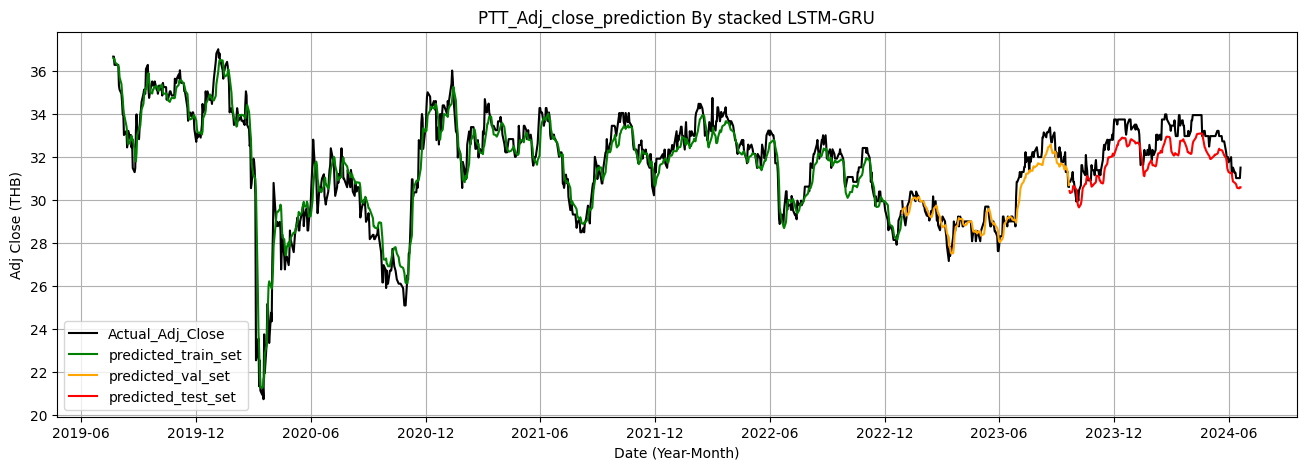

In [18]:
# Visualizing Results
plt.figure(figsize=(16, 5))

# Actual prices
plt.plot(date_train, inv_y_train[:, 0], color='black', label='Actual_Adj_Close')
plt.plot(date_val, inv_y_val[:, 0], color='black')
plt.plot(date_test, inv_y_test[:, 0], color='black')

# Predicted prices
plt.plot(date_train, inv_yhat_train[:, 0], color='green', label='predicted_train_set')
plt.plot(date_val, inv_yhat_val[:, 0], color='orange', label='predicted_val_set')
plt.plot(date_test, inv_yhat_test[:, 0], color='red', label='predicted_test_set')

# ตั้งค่าช่วงเวลาบนแกน X ให้แสดงผลทุก 6 เดือน
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# ตั้งค่าการแสดงผลของแกน X เป็นรูปแบบ 'Jan 2023', 'Feb 2023' เป็นต้น
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# ตั้งชื่อกราฟ
plt.title('PTT_Adj_close_prediction By stacked LSTM-GRU')
plt.xlabel('Date (Year-Month)')
plt.ylabel('Adj Close (THB)')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# คำนวณ MAPE และ RMSE
mape = mean_absolute_percentage_error(inv_y_test, inv_yhat_test)*100
rmse = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))

# แสดงผลลัพธ์
print(f'MAPE: {mape:.4f}%')
print(f'RMSE: {rmse:.4f}')


MAPE: 2.1985%
RMSE: 0.8577
